# IT5006 Group Project - FD003
**Group 6**

Gong Yifei (A0275740B)  
Jiao Yuehan (A0290548W)  
Loh Hui Wen (A0274301R)  
Tan Xin Ying Geraldine (A0274591W)   
Zhang Junti (A0274854R)

For this dataset, we conducted:
- **Experiment 1**: Traditional Machine Learning without Tsfresh
- **Experiment 2**: Various ML & DL Models Using Selected Sensors with Tsfresh 
- **Experiment 3**: Various ML & DL Models Using All Features with Tsfresh

## Experiment 1: Traditional Machine Learning without Tsfresh

### 1.1 Load train data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [2]:
col_names = ['unit_id', 'cycle', 'sys1', 'sys2', 'sys3'] + [f"sensor{i}" for i in range(1, 22)]

df = pd.read_csv('data/train_FD003.txt', delim_whitespace=True, header=None, names=col_names)

### 1.2 Perform basic checks
#### Check for null/missing values
For FD003 we don't see null values:

In [3]:
for col in df.columns:
    if(df[col].isnull().any()):
        print("Column ",col," has null value(s).")
        df[col] = df.groupby('unit_id')[col].transform(lambda x: x.fillna(x.mean()))
# df.describe()

#### Find missing cycle per unit (if any)
For FD003 we don't see missing cycles in the raw data:

In [4]:
def find_missing_cycles(df):
    missing_cycles = {}
    for unit_id, group in df.groupby('unit_id'):
        actual_cycles = group['cycle'].values
        expected_cycles = list(range(1, group['cycle'].max() + 1))  # Create the expected cycle sequence
        missing = sorted(set(expected_cycles) - set(actual_cycles))  # Compare and find missing cycles
        if missing:
            missing_cycles[unit_id] = missing
    return missing_cycles

missing_cycles = find_missing_cycles(df)
if (len(missing_cycles)):
    print(missing_cycles)

### 1.3 Add Remaining Useful Life (RUL) as target

In [5]:
df['RUL'] = df.groupby('unit_id')['cycle'].transform(lambda x: x.max() - x).clip(upper=130)
#df

### 1.4 Exploratory Data Analysis
#### Statistical summary

In [6]:
print(df.shape)
pd.set_option('display.max_columns', None)
df.describe()

(24720, 27)


,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,2.472000e+04,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,5.186700e+02,642.457858,1588.079175,1404.471212,1.462000e+01,21.595841,555.143808,2388.071555,9064.110809,1.301232,47.415707,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024,95.554207
std,29.348985,98.846675,0.002194,0.000294,0.0,6.684921e-11,0.523031,6.810418,9.773178,3.602525e-12,0.018116,3.437343,0.158285,19.980294,0.003485,0.300074,3.255314,0.158121,16.504118,0.060512,1.750371e-14,1.761459,0.0,0.0,0.248865,0.149234,42.548144
min,1.000000,1.000000,-0.008600,-0.000600,100.0,5.186700e+02,640.840000,1564.300000,1377.060000,1.462000e+01,21.450000,549.610000,2386.900000,9017.980000,1.290000,46.690000,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600,0.000000
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.080000,1583.280000,1397.187500,1.462000e+01,21.580000,553.110000,2388.000000,9051.920000,1.300000,47.190000,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200,61.000000
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,5.186700e+02,642.400000,1587.520000,1402.910000,1.462000e+01,21.600000,554.050000,2388.070000,9060.010000,1.300000,47.360000,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600,123.000000
75%,74.000000,191.000000,0.001500,0.000300,100.0,5.186700e+02,642.790000,1592.412500,1410.600000,1.462000e+01,21.610000,556.040000,2388.140000,9070.092500,1.300000,47.600000,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300,130.000000
max,100.000000,525.000000,0.008600,0.000700,100.0,5.186700e+02,645.110000,1615.390000,1441.160000,1.462000e+01,21.610000,570.490000,2388.600000,9234.350000,1.320000,48.440000,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500,130.000000


#### Box plot

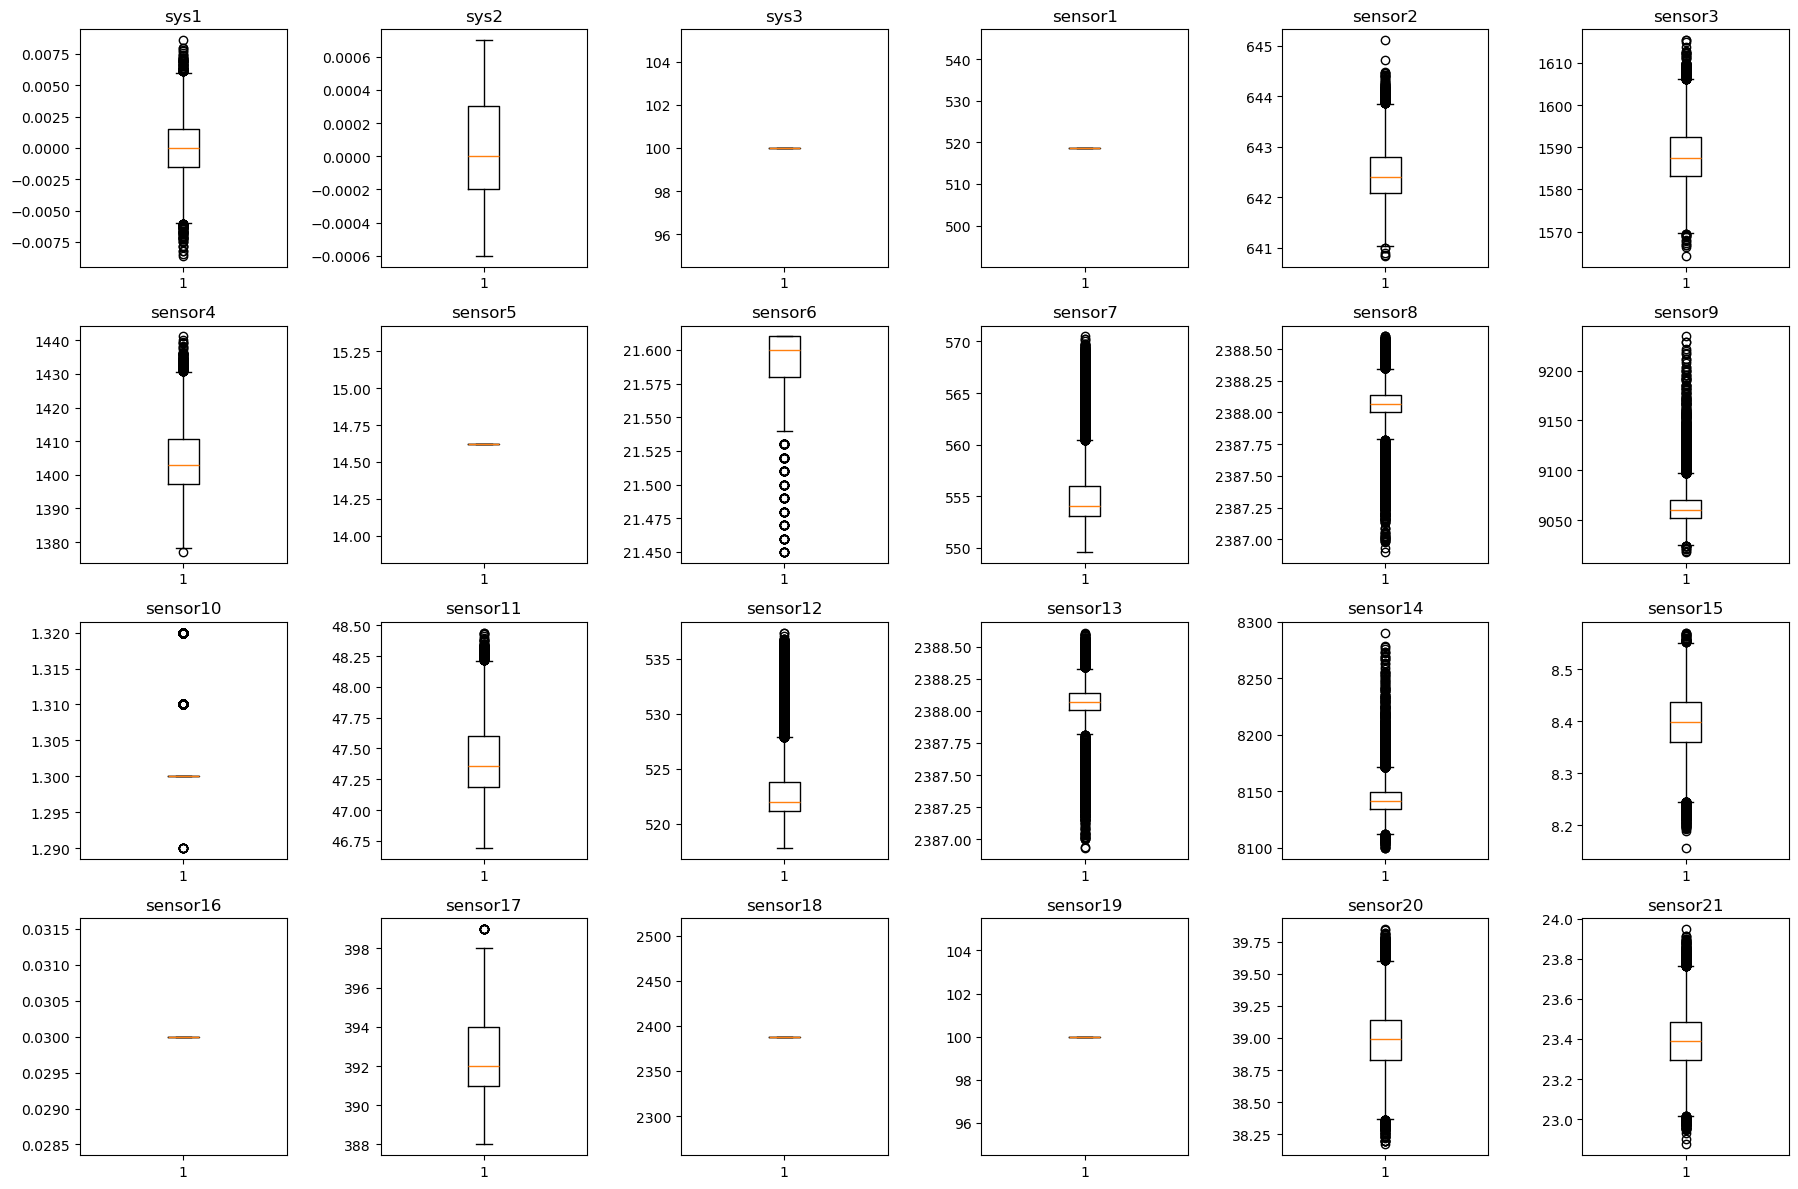

In [7]:
# Create a grid of subplots
unit_id = 1
cols = df.columns
cols = cols[~cols.isin(['unit_id', 'cycle', 'RUL'])]

fig, axes = plt.subplots(4, 6, figsize = (18, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

By analysing the box plots above, we can find fields 'sys3', 'sensor1', 'sensor5', 'sensor16', 'sensor18' and 'sensor19' are not changing much through the entire engine life, therefore we can drop them directly.

For sensor10, we can dig a bit deeper:

In [8]:
print("Sensor10 variance: ", df['sensor10'].var())
df['sensor10'].value_counts()

Sensor10 variance:  1.2144172832734506e-05


sensor10
1.30    21814
1.31     2740
1.32      157
1.29        9
Name: count, dtype: int64

With a variance of 1.21e-5, and values not differenciate much (about 90% of instances being the same value with min-max spread of 0.03), we can confidently drop it as well.

In [9]:
static_cols = ['sys3', 'sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19'];
df.drop(columns=static_cols, inplace=True)

#### Crrelation heatmap

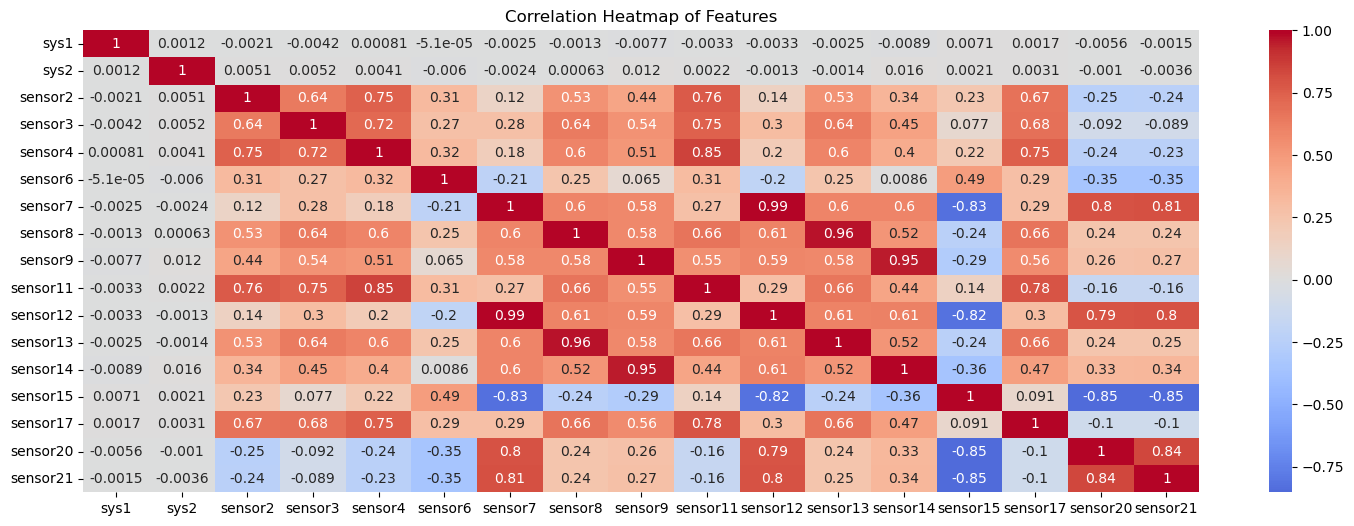

In [10]:
cols = cols[~cols.isin(static_cols)]
correlation_matrix = df[cols].corr()
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Features')
plt.show()

From the correlation heatmap above we can see sensor7 and sensor12 are highly correlated (0.99). We can consider only keep one of them.

In [11]:
df.drop(columns='sensor12', inplace=True)
cols = cols.drop('sensor12')

#### Line plot of one unit

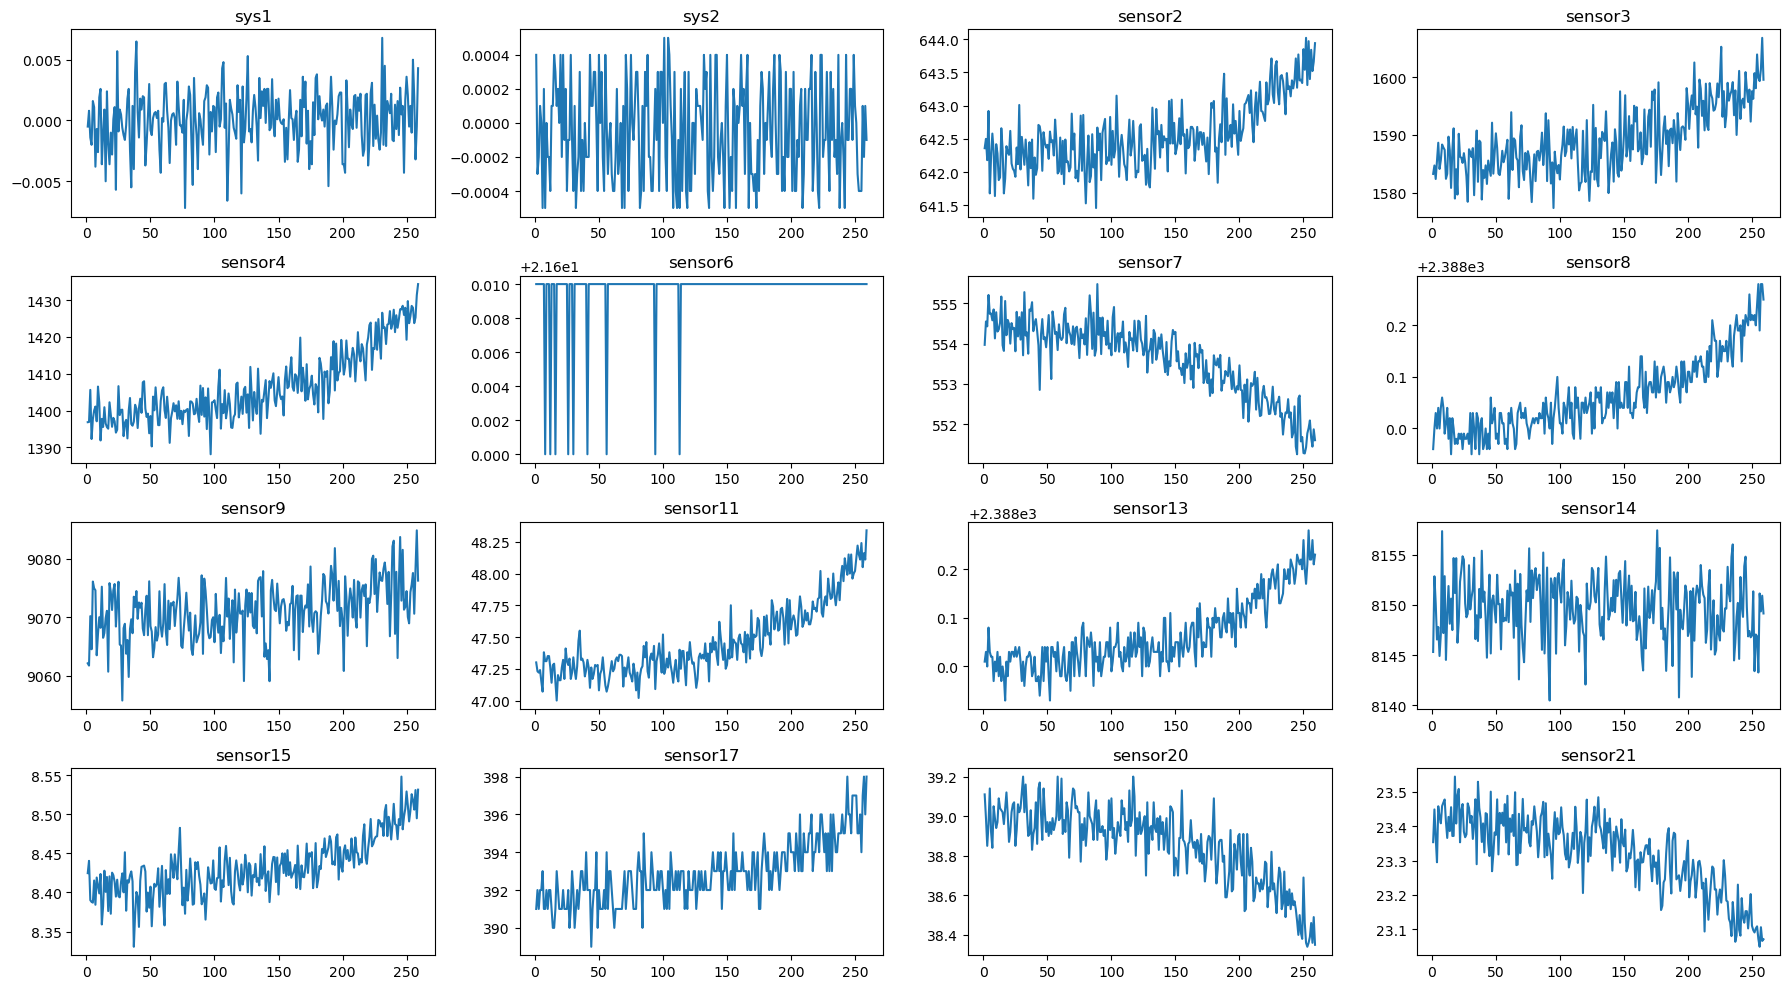

In [20]:
# Create a grid of subplots
unit_id = 1
unit_df = df[df['unit_id'] == unit_id]

fig, axes = plt.subplots(4, 4, figsize = (18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].plot(unit_df['cycle'], unit_df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In the line plots above, we can see sensor6 is a bit strange. We can dig check further on this feature:

In [21]:
print("Sensor6 variance: ", df['sensor6'].var())
df['sensor6'].value_counts()

Sensor6 variance:  0.0003281894577576316


sensor6
21.61    12186
21.60     3306
21.58     3098
21.57     3082
21.59     2075
21.56      734
21.55       57
21.54       31
21.53       26
21.52       24
21.51       20
21.50       16
21.49       16
21.48       14
21.47       14
21.46       12
21.45        9
Name: count, dtype: int64

As we can see, this feature can be dropped as well because it is also near-constant.
In summary, we'll use the columns below for further analysis:

In [22]:
df.drop(columns='sensor6', inplace=True)
cols = cols.drop('sensor6')
print(cols)

Index(['sys1', 'sys2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
       'sensor9', 'sensor11', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
       'sensor20', 'sensor21'],
      dtype='object')


### 1.5 Feature Engineering
#### Create new features

In [23]:
def create_features(df, window_size):
    # Initialize new features dataframe
    features = pd.DataFrame()
    features['unit_id'] = df['unit_id']
    features['cycle'] = df['cycle']

    # 1. Static statistical features
    sensor_cols = [col for col in df.columns if col.startswith('sensor')]
    agg_dict = {col: ['mean', 'std', 'min', 'max', 'var', skew, kurtosis] for col in sensor_cols}
    statistical_features = df.groupby('unit_id').agg(agg_dict)
    statistical_features.columns = ['_static_'.join(col) for col in statistical_features.columns]
    features = features.merge(statistical_features, on='unit_id', how='left')

    # 2. Rolling statistical features (using window_size)
    rolling_window = []
    stat_functions = {
        'mean': np.mean,
        'std': np.std,
        'min': np.min,
        'max': np.max,
        'var': np.var,
        'skew': skew,
        'kurtosis': kurtosis
    }
    
    for stat_name, stat_function in stat_functions.items():
        rolling_result = df.groupby('unit_id').rolling(window=window_size, on='cycle')[sensor_cols].apply(stat_function).reset_index()
        rolling_result = rolling_result[sensor_cols]
        rolling_result.columns = [f'{col}_rolling_{stat_name}' for col in sensor_cols]
        rolling_window.append(rolling_result)
    
    rolling_window = pd.concat(rolling_window, axis=1)
    features = pd.concat([features, rolling_window], axis=1)

    # 3. Immediate diff feature
    for col in sensor_cols:
        features[f'{col}_diff'] = df.groupby('unit_id')[col].diff()

    # 4. Rolling trend features
    for col in sensor_cols:
        slopes = []
        for unit_id in df['unit_id'].unique():
            unit_data = df[df['unit_id'] == unit_id]
            for i in range(len(unit_data)):
                if i < window_size - 1:
                    slopes.append(0)
                else:
                    y = unit_data.iloc[i-window_size+1:i+1][col].values
                    x = np.array(range(window_size)).reshape(-1, 1)
                    model = LinearRegression().fit(x, y)
                    slopes.append(model.coef_[0])
        features[f'{col}_rolling_slope'] = slopes

    # 5. Lag features
    lag_values = [5, 10]
    for col in sensor_cols:
        for lag in lag_values:
            features[f'{col}_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag)

    # 6. Rolling lag features
    rolling_lag_values = [5, 10]
    for col in sensor_cols:
        for lag in rolling_lag_values:
            features[f'{col}_rolling_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag).rolling(window=window_size).mean()
                
    df_with_features = pd.concat([df, features.drop(columns=['unit_id', 'cycle']).reset_index(drop=True)], axis=1)
    return df_with_features


def create_temperature_pressure_ratio_features(df, window_size):
    # Create ratios for temperature sensors 1, 2, 3, 4 against pressure sensors 5, 6, 7
    # After dropping highly correlated and near-constant featrures, this map is reduced to sensors 2, 3, 4 to sensor 7
    sensor_numerators = ['sensor2', 'sensor3', 'sensor4']
    sensor_denominators = ['sensor7']

    for num in sensor_numerators:
        for denom in sensor_denominators:
            df[f'tp_ratio_{num}_to_{denom}'] = df[num] / (df[denom] + 1e-6) # add a small number to avoid division by 0
            df[f'rolling_mean_ratio_{num}_to_{denom}'] = df[f'{num}_rolling_mean'] / (df[f'{denom}_rolling_mean'] + 1e-6)

    return df

As we observed from previous literature review, we'll start with rolling window of 30, which is a common window size chosen by majority of previous researches.

In [24]:
window_size = 30
train_df = create_features(df, window_size)
train_df = create_temperature_pressure_ratio_features(train_df, window_size)
train_df.head()

,unit_id,cycle,sys1,sys2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor4_static_mean,sensor4_static_std,sensor4_static_min,sensor4_static_max,sensor4_static_var,sensor4_static_skew,sensor4_static_kurtosis,sensor7_static_mean,sensor7_static_std,sensor7_static_min,sensor7_static_max,sensor7_static_var,sensor7_static_skew,sensor7_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor9_static_mean,sensor9_static_std,sensor9_static_min,sensor9_static_max,sensor9_static_var,sensor9_static_skew,sensor9_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor13_static_mean,sensor13_static_std,sensor13_static_min,sensor13_static_max,sensor13_static_var,sensor13_static_skew,sensor13_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor17_static_mean,sensor17_static_std,sensor17_static_min,sensor17_static_max,sensor17_static_var,sensor17_static_skew,sensor17_static_kurtosis,sensor20_static_mean,sensor20_static_std,sensor20_static_min,sensor20_static_max,sensor20_static_var,sensor20_static_skew,sensor20_static_kurtosis,sensor21_static_mean,sensor21_static_std,sensor21_static_min,sensor21_static_max,sensor21_static_var,sensor21_static_skew,sensor21_static_kurtosis,sensor2_rolling_mean,sensor3_rolling_mean,sensor4_rolling_mean,sensor7_rolling_mean,sensor8_rolling_mean,sensor9_rolling_mean,sensor11_rolling_mean,sensor13_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor17_rolling_mean,sensor20_rolling_mean,sensor21_rolling_mean,sensor2_rolling_std,sensor3_rolling_std,sensor4_rolling_std,sensor7_rolling_std,sensor8_rolling_std,sensor9_rolling_std,sensor11_rolling_std,sensor13_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor17_rolling_std,sensor20_rolling_std,sensor21_rolling_std,sensor2_rolling_min,sensor3_rolling_min,sensor4_rolling_min,sensor7_rolling_min,sensor8_rolling_min,sensor9_rolling_min,sensor11_rolling_min,sensor13_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor17_rolling_min,sensor20_rolling_min,sensor21_rolling_min,sensor2_rolling_max,sensor3_rolling_max,sensor4_rolling_max,sensor7_rolling_max,sensor8_rolling_max,sensor9_rolling_max,sensor11_rolling_max,sensor13_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor17_rolling_max,sensor20_rolling_max,sensor21_rolling_max,sensor2_rolling_var,sensor3_rolling_var,sensor4_rolling_var,sensor7_rolling_var,sensor8_rolling_var,sensor9_rolling_var,sensor11_rolling_var,sensor13_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor17_rolling_var,sensor20_rolling_var,sensor21_rolling_var,sensor2_rolling_skew,sensor3_rolling_skew,sensor4_rolling_skew,sensor7_rolling_skew,sensor8_rolling_skew,sensor9_rolling_skew,sensor11_rolling_skew,sensor13_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor17_rolling_skew,sensor20_rolling_skew,sensor21_rolling_skew,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor4_rolling_kurtosis,sensor7_rolling_kurtosis,sensor8_rolling_kurtosis,sensor9_rolling_kurtosis,sensor11_rolling_kurtosis,sensor13_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor17_rolling_kurtosis,sensor20_rolling_kurtosis,sensor21_rolling_kurtosis,sensor2_diff,sensor3_diff,senso

#### Pre-processing all features

In [25]:
# Handle missing values by replacing infinite values and dropping NaNs
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna()
train_df = train_df.apply(pd.to_numeric, errors='coerce').dropna()

train_df_features = train_df.drop(columns=['unit_id','cycle','RUL'])
train_df_seq = train_df[['unit_id','cycle']]
train_df_target = train_df['RUL']

# Min-Max scaling
scaler = MinMaxScaler()
scaler.fit(train_df_features)

train_df_features_scaled = pd.DataFrame(scaler.fit_transform(train_df_features), columns=train_df_features.columns, index=train_df_features.index)
train_df_scaled = pd.concat([train_df_seq, train_df_features_scaled, train_df_target], axis=1)

train_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor4_static_mean,sensor4_static_std,sensor4_static_min,sensor4_static_max,sensor4_static_var,sensor4_static_skew,sensor4_static_kurtosis,sensor7_static_mean,sensor7_static_std,sensor7_static_min,sensor7_static_max,sensor7_static_var,sensor7_static_skew,sensor7_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor9_static_mean,sensor9_static_std,sensor9_static_min,sensor9_static_max,sensor9_static_var,sensor9_static_skew,sensor9_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor13_static_mean,sensor13_static_std,sensor13_static_min,sensor13_static_max,sensor13_static_var,sensor13_static_skew,sensor13_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor17_static_mean,sensor17_static_std,sensor17_static_min,sensor17_static_max,sensor17_static_var,sensor17_static_skew,sensor17_static_kurtosis,sensor20_static_mean,sensor20_static_std,sensor20_static_min,sensor20_static_max,sensor20_static_var,sensor20_static_skew,sensor20_static_kurtosis,sensor21_static_mean,sensor21_static_std,sensor21_static_min,sensor21_static_max,sensor21_static_var,sensor21_static_skew,sensor21_static_kurtosis,sensor2_rolling_mean,sensor3_rolling_mean,sensor4_rolling_mean,sensor7_rolling_mean,sensor8_rolling_mean,sensor9_rolling_mean,sensor11_rolling_mean,sensor13_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor17_rolling_mean,sensor20_rolling_mean,sensor21_rolling_mean,sensor2_rolling_std,sensor3_rolling_std,sensor4_rolling_std,sensor7_rolling_std,sensor8_rolling_std,sensor9_rolling_std,sensor11_rolling_std,sensor13_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor17_rolling_std,sensor20_rolling_std,sensor21_rolling_std,sensor2_rolling_min,sensor3_rolling_min,sensor4_rolling_min,sensor7_rolling_min,sensor8_rolling_min,sensor9_rolling_min,sensor11_rolling_min,sensor13_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor17_rolling_min,sensor20_rolling_min,sensor21_rolling_min,sensor2_rolling_max,sensor3_rolling_max,sensor4_rolling_max,sensor7_rolling_max,sensor8_rolling_max,sensor9_rolling_max,sensor11_rolling_max,sensor13_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor17_rolling_max,sensor20_rolling_max,sensor21_rolling_max,sensor2_rolling_var,sensor3_rolling_var,sensor4_rolling_var,sensor7_rolling_var,sensor8_rolling_var,sensor9_rolling_var,sensor11_rolling_var,sensor13_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor17_rolling_var,sensor20_rolling_var,sensor21_rolling_var,sensor2_rolling_skew,sensor3_rolling_skew,sensor4_rolling_skew,sensor7_rolling_skew,sensor8_rolling_skew,sensor9_rolling_skew,sensor11_rolling_skew,sensor13_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor17_rolling_skew,sensor20_rolling_skew,sensor21_rolling_skew,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor4_rolling_kurtosis,sensor7_rolling_kurtosis,sensor8_rolling_kurtosis,sensor9_rolling_kurtosis,sensor11_rolling_kurtosis,sensor13_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor17_rolling_kurtosis,sensor20_rolling_kurtosis,sensor21_rolling_kurtosis,sensor2_diff,sensor3_diff,sensor4_d

### 1.6 Apply the same steps to test data set
#### Prepare X_test (test_FD003.txt)

In [28]:
test_df = pd.read_csv('data/test_FD003.txt', delim_whitespace=True, header=None, names=col_names)
test_df = test_df[['unit_id', 'cycle'] + list(cols)]

window_size = 30
test_df = create_features(test_df, window_size)
test_df = create_temperature_pressure_ratio_features(test_df, window_size)

test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna()
test_df = test_df.apply(pd.to_numeric, errors='coerce').dropna()

In [29]:
test_df_features = test_df.drop(columns=['unit_id','cycle'])
test_df_seq = test_df[['unit_id','cycle']]

# Reuse the min-max scaler fitted using training data to scale the test data
test_df_features_scaled = pd.DataFrame(scaler.fit_transform(test_df_features), columns=test_df_features.columns, index=test_df_features.index)
test_df_scaled = pd.concat([test_df_seq, test_df_features_scaled], axis=1)

# This is our X_test
test_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor4_static_mean,sensor4_static_std,sensor4_static_min,sensor4_static_max,sensor4_static_var,sensor4_static_skew,sensor4_static_kurtosis,sensor7_static_mean,sensor7_static_std,sensor7_static_min,sensor7_static_max,sensor7_static_var,sensor7_static_skew,sensor7_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor9_static_mean,sensor9_static_std,sensor9_static_min,sensor9_static_max,sensor9_static_var,sensor9_static_skew,sensor9_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor13_static_mean,sensor13_static_std,sensor13_static_min,sensor13_static_max,sensor13_static_var,sensor13_static_skew,sensor13_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor17_static_mean,sensor17_static_std,sensor17_static_min,sensor17_static_max,sensor17_static_var,sensor17_static_skew,sensor17_static_kurtosis,sensor20_static_mean,sensor20_static_std,sensor20_static_min,sensor20_static_max,sensor20_static_var,sensor20_static_skew,sensor20_static_kurtosis,sensor21_static_mean,sensor21_static_std,sensor21_static_min,sensor21_static_max,sensor21_static_var,sensor21_static_skew,sensor21_static_kurtosis,sensor2_rolling_mean,sensor3_rolling_mean,sensor4_rolling_mean,sensor7_rolling_mean,sensor8_rolling_mean,sensor9_rolling_mean,sensor11_rolling_mean,sensor13_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor17_rolling_mean,sensor20_rolling_mean,sensor21_rolling_mean,sensor2_rolling_std,sensor3_rolling_std,sensor4_rolling_std,sensor7_rolling_std,sensor8_rolling_std,sensor9_rolling_std,sensor11_rolling_std,sensor13_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor17_rolling_std,sensor20_rolling_std,sensor21_rolling_std,sensor2_rolling_min,sensor3_rolling_min,sensor4_rolling_min,sensor7_rolling_min,sensor8_rolling_min,sensor9_rolling_min,sensor11_rolling_min,sensor13_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor17_rolling_min,sensor20_rolling_min,sensor21_rolling_min,sensor2_rolling_max,sensor3_rolling_max,sensor4_rolling_max,sensor7_rolling_max,sensor8_rolling_max,sensor9_rolling_max,sensor11_rolling_max,sensor13_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor17_rolling_max,sensor20_rolling_max,sensor21_rolling_max,sensor2_rolling_var,sensor3_rolling_var,sensor4_rolling_var,sensor7_rolling_var,sensor8_rolling_var,sensor9_rolling_var,sensor11_rolling_var,sensor13_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor17_rolling_var,sensor20_rolling_var,sensor21_rolling_var,sensor2_rolling_skew,sensor3_rolling_skew,sensor4_rolling_skew,sensor7_rolling_skew,sensor8_rolling_skew,sensor9_rolling_skew,sensor11_rolling_skew,sensor13_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor17_rolling_skew,sensor20_rolling_skew,sensor21_rolling_skew,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor4_rolling_kurtosis,sensor7_rolling_kurtosis,sensor8_rolling_kurtosis,sensor9_rolling_kurtosis,sensor11_rolling_kurtosis,sensor13_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor17_rolling_kurtosis,sensor20_rolling_kurtosis,sensor21_rolling_kurtosis,sensor2_diff,sensor3_diff,sensor4_d

#### Prepare y_test (RUL_FD003.txt)

In [38]:
RUL_df = pd.read_csv('data/RUL_FD003.txt', delim_whitespace=True, header=None, names=['RUL'])
RUL_df['unit_id'] = range(1, len(RUL_df) + 1)
RUL_df['RUL'] = RUL_df['RUL'].clip(upper=130)
#RUL_df.describe()

### 1.7 Build random forest model using all features

In [55]:
from sklearn.model_selection import train_test_split,GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def fit_model(X, y, model, param_grid):
    # Set up TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    return grid_search

def get_best_rmse(model, X_train, X_test):
    # get results for train set
    y_pred = model.predict(X_train)
    y_train = train_df_scaled['RUL']

    train_mse = mean_squared_error(y_train, y_pred)
    train_rmse = np.sqrt(train_mse)
    print(f'Root Mean Squared Error (RMSE) for train set prediction: {train_rmse}')

    # get results for test set
    y_pred = model.predict(X_test)
    y_pred_df = pd.DataFrame({'unit_id': test_df_scaled['unit_id'].values, 'RUL_pred': y_pred}).groupby('unit_id').tail(1)
    test_res_df = pd.merge(y_pred_df, RUL_df, on='unit_id', how='left')

    test_mse = mean_squared_error(test_res_df['RUL'], test_res_df['RUL_pred'])
    test_rmse = np.sqrt(test_mse)
    print(f'Root Mean Squared Error (RMSE) for test set prediction: {test_rmse}')
    
    return test_res_df

def plot_feature_importances(model, cols, n):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1][:n]

    top_features = feature_importance[indices]
    top_feature_names = cols[indices]

    plt.figure(figsize=(8, 4))
    plt.title(f"Top {n} Feature Importances")
    plt.barh(top_feature_names, top_features, color="blue", align="center")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.show()


#### Evaluate model and plot feature importances

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}
Root Mean Squared Error (RMSE) for train set prediction: 4.256053930346657
Root Mean Squared Error (RMSE) for test set prediction: 31.817890089726824


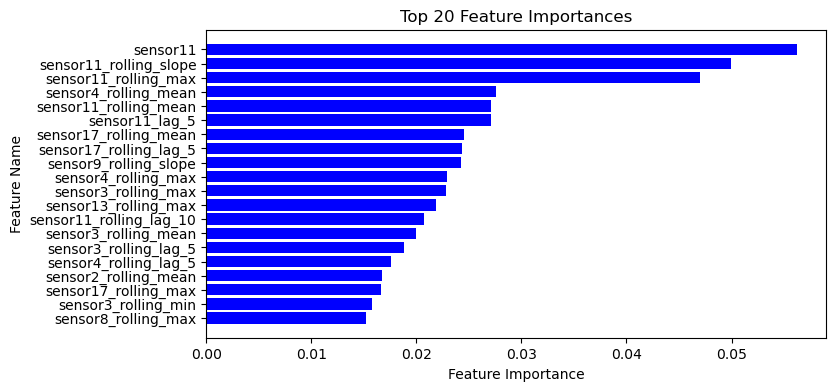

In [73]:
# Select features and target
X_train = train_df_scaled.drop(columns=['RUL', 'unit_id', 'cycle'])
y_train = train_df_scaled['RUL'] # Note: RUL is not scaled
X_test = test_df_scaled.drop(columns=['unit_id', 'cycle'])
y_test = RUL_df['RUL']

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [6, 9, 12],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search_rf = fit_model(X_train, y_train, rf_model, param_grid)

# Best parameters
print(f'Best Parameters: {grid_search_rf.best_params_}')

best_rf_model = grid_search_rf.best_estimator_

# Make predictions
rf_res_df = get_best_rmse(best_rf_model, X_train, X_test)

plot_feature_importances(best_rf_model, X_train.columns, 20)

### 1.8 Build ramdom forest model using rolling features

Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 300}
Root Mean Squared Error (RMSE) for train set prediction: 7.20253253504708
Root Mean Squared Error (RMSE) for test set prediction: 35.78005830237665


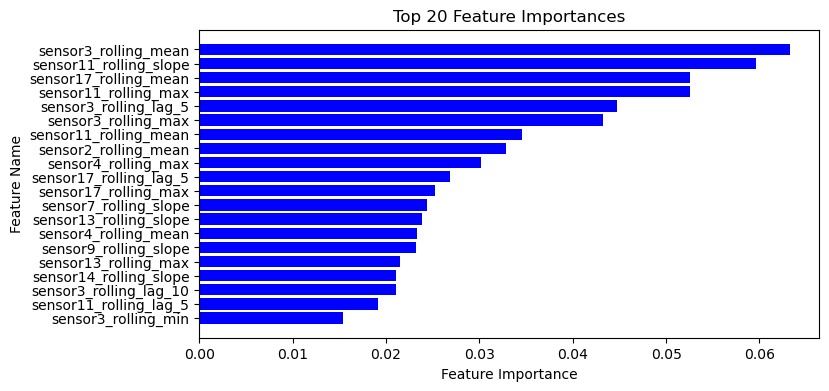

In [66]:
X_train_rolling = train_df_scaled.filter(like='rolling')
X_test_rolling = test_df_scaled.filter(like='rolling')

rf_rolling_model = RandomForestRegressor(random_state=42)

param_grid_rf_rolling = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search_rf_rolling = fit_model(X_train_rolling, y_train, rf_rolling_model, param_grid_rf_rolling)

# Best parameters
print(f'Best Parameters: {grid_search_rf_rolling.best_params_}')

best_rf_rolling_model = grid_search_rf_rolling.best_estimator_

# Make predictions
rf_rolling_res_df = get_best_rmse(best_rf_rolling_model, X_train_rolling, X_test_rolling)

plot_feature_importances(best_rf_rolling_model, X_train_rolling.columns, 20)

### 1.9 Build LightGBM model using all features

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


C:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51725
[LightGBM] [Info] Number of data points in the train set: 20820, number of used features: 281
[LightGBM] [Info] Start training from score 89.153314
Best Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 40, 'n_estimators': 200, 'num_leaves': 15, 'reg_alpha': 0.5, 'subsample': 0.6}
Root Mean Squared Error (RMSE) for train set prediction: 4.449042333135004
Root Mean Squared Error (RMSE) for test set prediction: 35.70000963590692


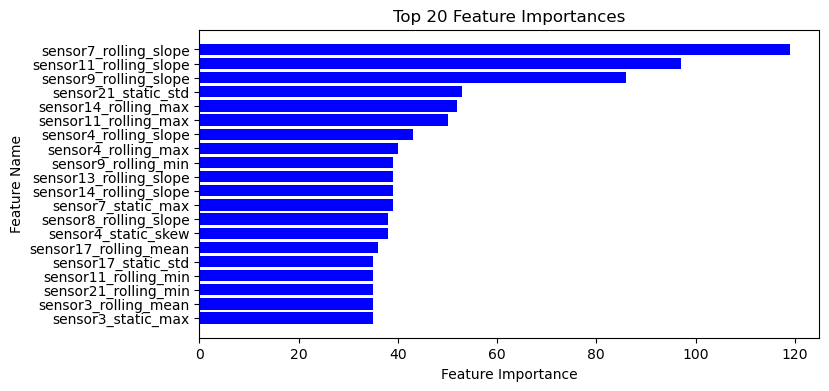

In [75]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(random_state=42)

param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 15, 20],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 7, 10],
    'subsample': [0.6, 0.8],
    'reg_alpha': [0.1, 0.5, 1.0]
}

grid_search_lgb = fit_model(X_train, y_train, lgb_model, param_grid_lgb)

# Best parameters
print(f'Best Parameters: {grid_search_lgb.best_params_}')

best_lgb_model = grid_search_lgb.best_estimator_

# Make predictions
lgb_res_df = get_best_rmse(best_lgb_model, X_train, X_test)

plot_feature_importances(best_lgb_model, X_train.columns, 20)

## Experiment 2: Various ML & DL Models Using Selected Sensors with Tsfresh

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_selection.relevance import calculate_relevance_table

In [3]:
col_1 = ['unit', 'time', 'op1', 'op2', 'op3']
col_2 = [f'sr{i+1}' for i in range(21)]
columns = col_1 + col_2

# Load datasets and assign column names
df = pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\train_FD003.txt', delim_whitespace=True, header=None, names=columns)
test = pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\test_FD003.txt', delim_whitespace=True, header=None, names=columns)

# Add features to training data
df['max_time'] = df.groupby('unit')['time'].transform('max')
df['remaining_time'] = df['max_time'] - df['time']
df['label'] = df['remaining_time'].clip(upper=130)

# Preview data
df.head()

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr15,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8.4246,0.03,391,2388,100.0,39.11,23.3537,259,258,130
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8.4403,0.03,392,2388,100.0,38.99,23.4491,259,257,130
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8.3901,0.03,391,2388,100.0,38.85,23.3669,259,256,130
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8.3878,0.03,392,2388,100.0,38.96,23.2951,259,255,130
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8.3869,0.03,392,2388,100.0,39.14,23.4583,259,254,130


In [4]:
test.head()

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr12,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950


### 2.1 Exploratory data analysis

Same as Experiment 1, but we choose to remove all Operating system (selection done in section 2.3).

### 2.2 Data preprocessing

In [5]:
window_size = 30

rolling_params = {
    "column_id": "unit",
    "column_sort": "time",
    "max_timeshift": window_size - 1,
    "min_timeshift": window_size-1,
    "rolling_direction": 1
}

rolled_df = roll_time_series(df, **rolling_params)

rolled_test = roll_time_series(test, **rolling_params)

Rolling: 100%|██████████| 60/60 [00:06<00:00,  9.53it/s]


In [6]:
rolled_df

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label,id
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,0.03,391,2388,100.0,39.11,23.3537,259,258,130,"(1, 30)"
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,0.03,392,2388,100.0,38.99,23.4491,259,257,130,"(1, 30)"
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,0.03,391,2388,100.0,38.85,23.3669,259,256,130,"(1, 30)"
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,0.03,392,2388,100.0,38.96,23.2951,259,255,130,"(1, 30)"
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,0.03,392,2388,100.0,39.14,23.4583,259,254,130,"(1, 30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418585,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,0.03,394,2388,100.0,38.44,22.9631,152,4,4,"(100, 152)"
418586,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,0.03,395,2388,100.0,38.50,22.9746,152,3,3,"(100, 152)"
418587,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,0.03,396,2388,100.0,38.39,23.0682,152,2,2,"(100, 152)"
418588,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,0.03,395,2388,100.0,38.31,23.0753,152,1,1,"(100, 152)"


In [16]:
rolled_test

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21,id
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,"(1, 30)"
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,"(1, 30)"
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,"(1, 30)"
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,"(1, 30)"
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,"(1, 30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297865,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,"(100, 198)"
297866,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,"(100, 198)"
297867,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,"(100, 198)"
297868,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,"(100, 198)"


### 2.3 Feature engineering with Tsfresh

In [7]:
selected_cols=['id','sr2', 'sr3', 'sr4',
                    'sr7', 'sr8', 'sr9', 'sr11',
                    'sr12', 'sr13', 'sr14', 'sr15',
                    'sr17', 'sr20', 'sr21']

selected_df=rolled_df[selected_cols]
selected_test=rolled_test[selected_cols]

In [8]:
from tsfresh.feature_extraction import EfficientFCParameters
extraction_settings = EfficientFCParameters()

feature_params = {
    "column_id": "id",
    "impute_function": impute,
    "default_fc_parameters": extraction_settings
}

X = extract_features(selected_df, **feature_params)
x_test = extract_features(selected_test, **feature_params)

Feature Extraction: 100%|██████████| 60/60 [09:09<00:00,  9.16s/it]  


In [9]:
print(X.shape)
print(x_test.shape)

(21820, 10878)
(13696, 10878)


### 2.4 Feature selection with Tsfresh 

In [10]:
y=rolled_df.groupby('id')['label'].last()
X_filtered=select_features(X, y)
X_filtered

sr11__sum_values  \
1   30            1417.35   
    31            1417.29   
    32            1417.23   
    33            1417.28   
    34            1417.51   
...                   ...   
100 148           1438.70   
    149           1439.10   
    150           1439.37   
    151           1439.56   
    152           1439.86   

         sr8__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)  \
1   30                                         6167.099884             
    31                                         6167.106616             
    32                                         6167.105671             
    33                                         6167.097772             
    34                                         6167.096401             
...                                                    ...             
100 148                                        6167.550479             
    149                                        6167.559472             
    150                                        6167.566002             
    151                                        6167.581237             
    152                                        6167.586138             

         sr3__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"  \
1   30                                            0.039143               
    31                                           -0.248857               
    32                                           -0.288286               
    33                                           -0.404857               
    34                                           -0.346571               
...                                                    ...               
100 148                                           0.875429               
    149                                           0.917714               
    150                                           0.880571               
    151                                           1.282000               
    152                                           0.557143               

         sr8__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)  \
1   30                                         4476.125976             
    31                                         4476.145493             
    32                                         4476.151690             
    33                                         4476.149593             
    34                                         4476.151273             
...                                                    ...             
100 148                                        4476.419234             
    149                                        4476.433234             
    150                                        4476.440300             
    151                                        4476.451111             
    152                                        4476.451780             

         sr8__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)  \
1   30                                         1871.029133            
    31                                         1871.060067            
    32                                         1871.077017            
    33                                         1871.084451            
    34                                         1871.097860            
...                                                    ...            
100 148                                        1871.124240            
    149                                        1871.139659            
    150                                        1871.150327            
    151                                        1871.168104            
    152                                        1871.169470            

         sr13__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
1   30                                         3190.562050              
    31                                    

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_filtered)
relevant_features_scaled = scaler.transform(X_filtered)
relevant_features_scaled_df = pd.DataFrame(relevant_features_scaled, columns=X_filtered.columns)

selected_features = relevant_features_scaled_df.columns 
relevant_test_features = x_test[selected_features]
relevant_test_features_scaled = scaler.transform(relevant_test_features)
relevant_test_features_scaled_df = pd.DataFrame(relevant_test_features_scaled, columns=selected_features)

In [12]:
print(selected_features)

Index(['sr11__sum_values',
       'sr8__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)',
       'sr3__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"',
       'sr8__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)',
       'sr8__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)',
       'sr13__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
       'sr13__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'sr13__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'sr13__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'sr13__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)',
       ...
       'sr12__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0',
       'sr3__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
       'sr12__fft_coefficient__attr_"abs"__coeff_15',
       'sr15__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'sr12__change_quantiles__f_agg_"var"__isabs

In [13]:
print(relevant_features_scaled_df.shape)
print(relevant_test_features_scaled_df.shape)

(21820, 4290)
(13696, 4290)


### 2.5 Predictive modeling

In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(relevant_features_scaled_df, y, test_size=0.2, random_state=42)

In [15]:
rul_file_path = 'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\RUL_FD003.txt'
true_rul = pd.read_csv(rul_file_path, header=None, names=['RUL'])
true_rul['RUL'] = true_rul['RUL'].clip(upper=130)

# Assign the true RUL values to Y_test
y_test = true_rul['RUL']

In [16]:
def calculate_s_score(y_true, y_pred):
    # Calculate the error between predictions and actual values
    error = y_pred - y_true
    
    # Apply S-score calculation
    s_score = np.where(
        error <= 0, 
        np.exp(-error / 13) - 1, 
        np.exp(error / 10) - 1
    )
    
    # Return the mean S-score
    return np.mean(s_score)


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test=None, Y_test=None):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics for validation
    s_score = calculate_s_score(y_val, y_pred)
    mse_val = mean_squared_error(y_val, y_pred)
    rmse_val = mse_val ** 0.5
    
    # Print validation results
    model_name = model.__class__.__name__
    print(f'{model_name} model - Validation Set')
    print('RMSE:', rmse_val)
    print('S-score:', s_score)
    print('---------------------')
    
    results = {'model': model_name, 'rmse_val': rmse_val, 's_score': s_score}
    
    # If test set provided, predict and evaluate on test set
    if X_test is not None and Y_test is not None:
        y_pred_test = model.predict(X_test)
        temp = rolled_test.groupby('id').last()
        temp['prediction'] = y_pred_test
        Y_pred = temp.groupby('unit')['prediction'].last().to_numpy()
        
        # Calculate RMSE for test set
        s_test = calculate_s_score(Y_test, Y_pred)
        mse_test = mean_squared_error(Y_test, Y_pred)
        rmse_test = mse_test ** 0.5
        print(f'{model_name} model - Test Set')
        print('Test RMSE:', rmse_test)
        print('Test score:', s_test)
        print('---------------------')
        
        # Store test results in the results dictionary
        results.update({'rmse_test': rmse_test, 'test_score': s_test})
    
    return results

In [17]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin


def scheduler(epoch, optimizer):
    if epoch < 5:
        lr = 0.001
    else:
        lr = 0.0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class ConvLSTMModel(nn.Module):
    def __init__(self, input_channels, drop_CNN=0.1, drop_dense=0.1, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout1 = nn.Dropout(p=drop_CNN)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout2 = nn.Dropout(p=drop_CNN)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.dropout3 = nn.Dropout(p=drop_dense)
        self.dense1 = nn.Linear(128, 512)
        self.dense2 = nn.Linear(512, 128)
        self.dense3 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, window_length, input_channels)
        x = x.permute(0, 2, 1)  # Convert to (batch_size, input_channels, window_length)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)

        x = x.permute(0, 2, 1)  # Convert to (batch_size, seq_length, channels)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Dropout layer
        x = self.dropout3(x)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        
        return x


class ConvLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_channels=1, lr=0.001, batch_size=64, max_epoch=500, drop_CNN=0.1, drop_dense=0.1, kernel_size=3):
        self.lr = lr
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = ConvLSTMModel(input_channels=input_channels, drop_CNN=drop_CNN, drop_dense=drop_dense, kernel_size=kernel_size)

    def _prepare_input(self, X):
        """
        Detect input data dimensions:
        If the input is two-dimensional data (samples, features), a pseudo-time dimension is added (samples, 1, features).
        If the input is three-dimensional data (samples, seq_length, channels), it is returned directly.
        """
        if X.ndim == 2:
            X = np.expand_dims(X, axis=1)  # 增加伪时间维度
        return X

        
    def fit(self, X, y):
        # Detect and adjust input data dimensions
        X = self._prepare_input(X)

        # Convert X, y to torch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        # Define optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        # Training loop
        self.model.train()
        for epoch in range(self.max_epoch):
            running_loss = 0.0
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 1 == 0:
                print(f"Epoch {epoch + 1}/{self.max_epoch}, Loss: {running_loss/X_tensor.size(0):.4f}")

            # adjust learning rate based on epoch
            scheduler(epoch, optimizer)

        return self

    def predict(self, X):
        # Detect and adjust input data dimensions
        X = self._prepare_input(X)

        # Convert X to torch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Prediction
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
        
        return predictions.flatten()


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# from cnn_lstm import ConvLSTMRegressor

# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test=relevant_test_features_scaled_df, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison

results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 7.291450140098401
S-score: 0.882487103124113
---------------------
XGBRegressor model - Test Set
Test RMSE: 14.58388931508904
Test score: 4.0772129196553575
---------------------
RandomForestRegressor model - Validation Set
RMSE: 7.031118622610994
S-score: 0.8183049196286668
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 14.049841571868054
Test score: 3.5059574333361967
---------------------
MLPRegressor model - Validation Set
RMSE: 4.204695570810881
S-score: 0.38881928565738105
---------------------
MLPRegressor model - Test Set
Test RMSE: 1404.281876992291
Test score: 7.67401322396716e+64
---------------------
Epoch 1/10, Loss: 30.0924
Epoch 2/10, Loss: 1.2356
Epoch 3/10, Loss: 0.7305
Epoch 4/10, Loss: 0.5462
Epoch 5/10, Loss: 0.4678
Epoch 6/10, Loss: 0.3938
Epoch 7/10, Loss: 0.3163
Epoch 8/10, Loss: 0.2953
Epoch 9/10, Loss: 0.2854
Epoch 10/10, Loss: 0.2697
ConvLSTMRegressor model - Validation Set
RMSE: 3.294893545138

### 2.6 PCA dimension reduction to prevent overfitting

result did not improve after PCA dimension reduction

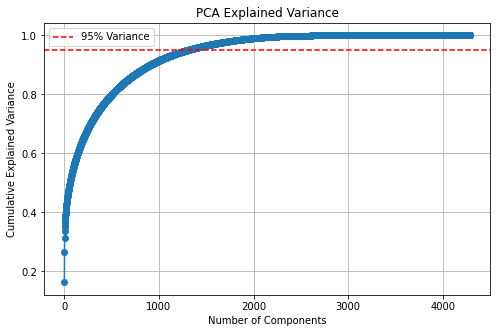

Optimal number of components for 95% variance: 1302


In [19]:
from sklearn.decomposition import PCA
pca = PCA()  # Adjust based on your dataset
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal number of components to retain at least 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components for 95% variance:", optimal_n_components)

In [20]:
pca = PCA(n_components=optimal_n_components)  # Adjust based on your dataset
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(relevant_test_features_scaled_df)

In [21]:
# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train_reduced.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train_reduced, y_train, X_val_reduced, y_val, X_test=X_test_reduced, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 9.278358205475396
S-score: 1.4243215151679718
---------------------
XGBRegressor model - Test Set
Test RMSE: 14.323611260334305
Test score: 4.9222008028335935
---------------------
RandomForestRegressor model - Validation Set
RMSE: 24.16049066921465
S-score: 15.548540704909458
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 35.038759279667836
Test score: 28.867320415627173
---------------------
MLPRegressor model - Validation Set
RMSE: 6.2963076526978
S-score: 18205.367617164993
---------------------
MLPRegressor model - Test Set
Test RMSE: 378.4242590855353
Test score: 2.323006718990785e+18
---------------------
Epoch 1/10, Loss: 18.4058
Epoch 2/10, Loss: 0.8071
Epoch 3/10, Loss: 0.5722
Epoch 4/10, Loss: 0.4843
Epoch 5/10, Loss: 0.4150
Epoch 6/10, Loss: 0.3835
Epoch 7/10, Loss: 0.3224
Epoch 8/10, Loss: 0.2933
Epoch 9/10, Loss: 0.2703
Epoch 10/10, Loss: 0.2574
ConvLSTMRegressor model - Validation Set
RMSE: 4.048144007401

### 2.7 Residual plot

result did not improve after PCA dimension reduction

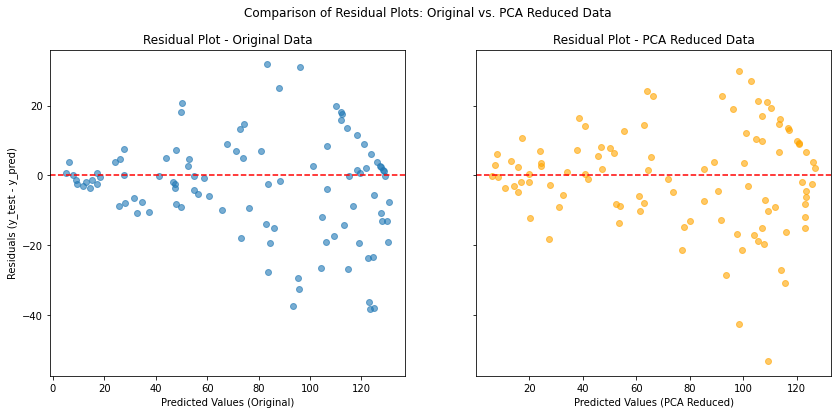

In [22]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)
y_pred = XGBoost.predict(relevant_test_features_scaled_df)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_original = temp.groupby('unit')['prediction'].last().to_numpy()

XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train_reduced, y_train)
y_pred = XGBoost.predict(X_test_reduced)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_pca = temp.groupby('unit')['prediction'].last().to_numpy()

residuals_original = y_test - y_pred_original
residuals_pca = y_test - y_pred_pca

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original data residual plot
axes[0].scatter(y_pred_original, residuals_original, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted Values (Original)")
axes[0].set_ylabel("Residuals (y_test - y_pred)")
axes[0].set_title("Residual Plot - Original Data")

# PCA-reduced data residual plot
axes[1].scatter(y_pred_pca, residuals_pca, alpha=0.6, color="orange")
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Values (PCA Reduced)")
axes[1].set_title("Residual Plot - PCA Reduced Data")

plt.suptitle("Comparison of Residual Plots: Original vs. PCA Reduced Data")
plt.show()

### 2.8 Feature importance

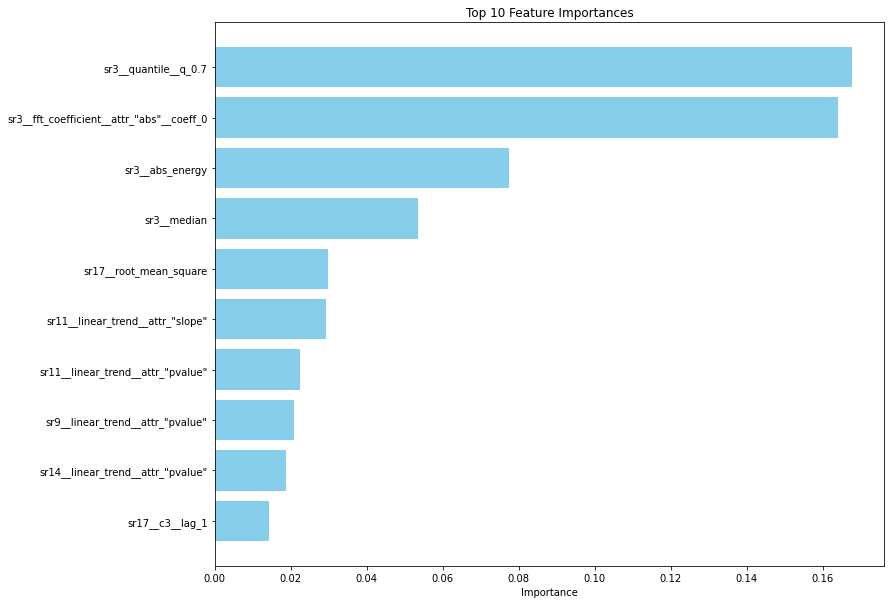

In [23]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)

# Get feature importances
importances = XGBoost.feature_importances_

# Create a DataFrame for easy sorting and selection
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Adjust if feature names are in a different variable
    'Importance': importances
})

# Sort by importance and select the top 100 features
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

## Experiment 3: Various ML & DL Models Using All Features with Tsfresh

In [24]:
#select and extract features (uses all sensors)
selected_cols=['id', 'sr1','sr2', 'sr3', 'sr4', 'sr5',
               'sr6', 'sr7', 'sr8', 'sr9', 'sr10',
                'sr11', 'sr12', 'sr13', 'sr14', 'sr15',
                'sr16', 'sr17', 'sr18', 'sr19', 'sr20', 'sr21']
selected_df=rolled_df[selected_cols]
selected_test=rolled_test[selected_cols]

In [25]:
feature_params = {
    "column_id": "id",
    "impute_function": impute,
    "default_fc_parameters": extraction_settings
}

X = extract_features(selected_df, **feature_params)
x_test = extract_features(selected_test, **feature_params)

print(X.shape)
print(x_test.shape)

Feature Extraction: 100%|██████████| 60/60 [13:35<00:00, 13.59s/it]  


(21820, 16317)
(13696, 16317)


In [26]:
y=rolled_df.groupby('id')['label'].last()
X_filtered=select_features(X, y)
X_filtered

sr2__sum_values  \
1   30          19267.27   
    31          19267.23   
    32          19266.84   
    33          19267.15   
    34          19266.44   
...                  ...   
100 148         19298.89   
    149         19299.41   
    150         19299.96   
    151         19300.94   
    152         19301.98   

         sr9__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)  \
1   30                                        19258.213388             
    31                                        19259.631087             
    32                                        19261.363535             
    33                                        19260.639326             
    34                                        19261.160014             
...                                                    ...             
100 148                                       19232.614362             
    149                                       19234.373290             
    150                                       19235.815608             
    151                                       19236.821245             
    152                                       19238.242873             

         sr9__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)  \
1   30                                         9432.661648            
    31                                         9435.513393            
    32                                         9437.495713            
    33                                         9436.748558            
    34                                         9436.381704            
...                                                    ...            
100 148                                        9414.216262            
    149                                        9414.534319            
    150                                        9415.420971            
    151                                        9416.634093            
    152                                        9418.602184            

         sr9__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)  \
1   30                                         5456.474602            
    31                                         5463.426227            
    32                                         5466.886306            
    33                                         5465.652165            
    34                                         5457.367110            
...                                                    ...            
100 148                                        5448.080712            
    149                                        5447.363858            
    150                                        5448.359432            
    151                                        5450.675294            
    152                                        5451.533516            

         sr9__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)  \
1   30                                        23419.911119             
    31                                        23421.691049             
    32                                        23423.508805             
    33                                        23423.539968             
    34                                        23424.900839             
...                                                    ...             
100 148                                       23394.635253             
    149                                       23395.702752             
    150                                       23396.379188             
    151                                       23397.246564             
    152                                       23398.811590             

         sr9__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)  \
1   30                                        16998.427460             
    31                                        16999.746753             
    32              

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_filtered)
relevant_features_scaled = scaler.transform(X_filtered)
relevant_features_scaled_df = pd.DataFrame(relevant_features_scaled, columns=X_filtered.columns)

selected_features = relevant_features_scaled_df.columns 
relevant_test_features = x_test[selected_features]
relevant_test_features_scaled = scaler.transform(relevant_test_features)
relevant_test_features_scaled_df = pd.DataFrame(relevant_test_features_scaled, columns=selected_features)

print(relevant_features_scaled_df.shape)
print(relevant_test_features_scaled_df.shape)

(21820, 5030)
(13696, 5030)


In [28]:
X_train, X_val, y_train, y_val = train_test_split(relevant_features_scaled_df, y, test_size=0.2, random_state=42)

In [29]:
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test=relevant_test_features_scaled_df, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison

results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 7.0845361646778535
S-score: 0.8321073653243776
---------------------
XGBRegressor model - Test Set
Test RMSE: 14.211025223739238
Test score: 3.6651999084372204
---------------------
RandomForestRegressor model - Validation Set
RMSE: 6.885637859957452
S-score: 0.7811508474127148
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 14.448331955989579
Test score: 3.9642208592409016
---------------------
MLPRegressor model - Validation Set
RMSE: 3.512195984068472
S-score: 0.3076951954105805
---------------------
MLPRegressor model - Test Set
Test RMSE: 542.2289795808024
Test score: 7.325107542986623e+25
---------------------
Epoch 1/10, Loss: 25.0327
Epoch 2/10, Loss: 0.9991
Epoch 3/10, Loss: 0.6206
Epoch 4/10, Loss: 0.4860
Epoch 5/10, Loss: 0.4228
Epoch 6/10, Loss: 0.3803
Epoch 7/10, Loss: 0.3037
Epoch 8/10, Loss: 0.2776
Epoch 9/10, Loss: 0.2715
Epoch 10/10, Loss: 0.2564
ConvLSTMRegressor model - Validation Set
RMSE: 3.155448414

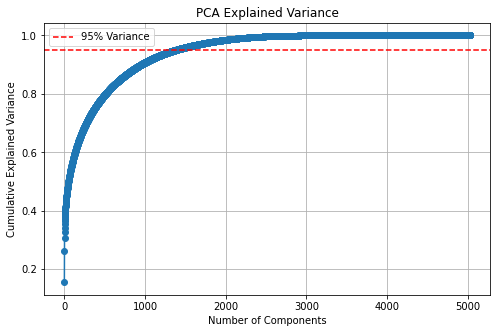

Optimal number of components for 95% variance: 1382


In [30]:
from sklearn.decomposition import PCA
pca = PCA()  # Adjust based on your dataset
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal number of components to retain at least 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components for 95% variance:", optimal_n_components)

In [31]:
pca = PCA(n_components=optimal_n_components)  # Adjust based on your dataset
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(relevant_test_features_scaled_df)

In [32]:
# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train_reduced.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train_reduced, y_train, X_val_reduced, y_val, X_test=X_test_reduced, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 8.946757524980148
S-score: 1.3107994529881595
---------------------
XGBRegressor model - Test Set
Test RMSE: 14.037983512057849
Test score: 4.899590452579262
---------------------
RandomForestRegressor model - Validation Set
RMSE: 23.015484315645796
S-score: 13.209924886223225
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 35.06054070976766
Test score: 32.61153439849418
---------------------
MLPRegressor model - Validation Set
RMSE: 4.440697429723603
S-score: 7.4539660081420545
---------------------
MLPRegressor model - Test Set
Test RMSE: 284.08533532399946
Test score: 62970575502550.7
---------------------
Epoch 1/10, Loss: 17.7563
Epoch 2/10, Loss: 0.7704
Epoch 3/10, Loss: 0.5279
Epoch 4/10, Loss: 0.4463
Epoch 5/10, Loss: 0.3935
Epoch 6/10, Loss: 0.3581
Epoch 7/10, Loss: 0.2938
Epoch 8/10, Loss: 0.2560
Epoch 9/10, Loss: 0.2420
Epoch 10/10, Loss: 0.2294
ConvLSTMRegressor model - Validation Set
RMSE: 3.6531954713388135

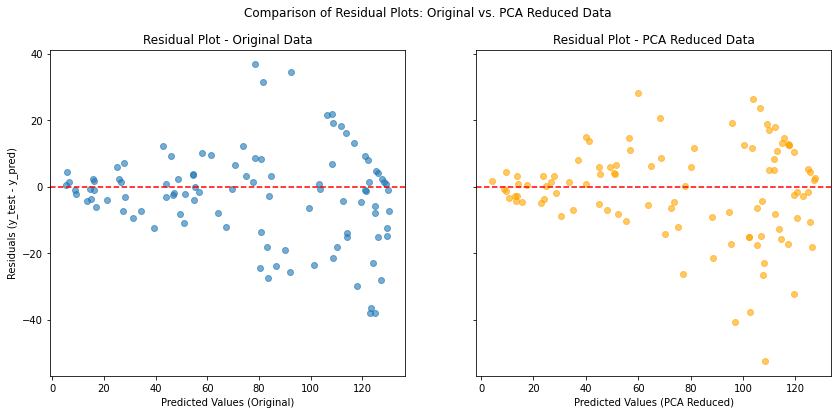

In [33]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)
y_pred = XGBoost.predict(relevant_test_features_scaled_df)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_original = temp.groupby('unit')['prediction'].last().to_numpy()

XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train_reduced, y_train)
y_pred = XGBoost.predict(X_test_reduced)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_pca = temp.groupby('unit')['prediction'].last().to_numpy()

residuals_original = y_test - y_pred_original
residuals_pca = y_test - y_pred_pca

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original data residual plot
axes[0].scatter(y_pred_original, residuals_original, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted Values (Original)")
axes[0].set_ylabel("Residuals (y_test - y_pred)")
axes[0].set_title("Residual Plot - Original Data")

# PCA-reduced data residual plot
axes[1].scatter(y_pred_pca, residuals_pca, alpha=0.6, color="orange")
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Values (PCA Reduced)")
axes[1].set_title("Residual Plot - PCA Reduced Data")

plt.suptitle("Comparison of Residual Plots: Original vs. PCA Reduced Data")
plt.show()

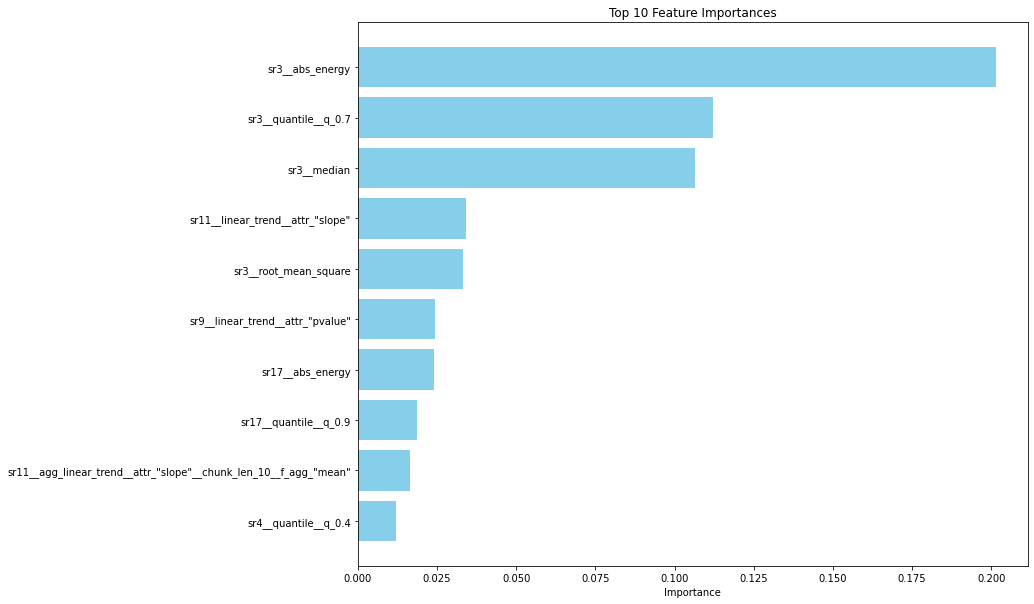

In [34]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)

# Get feature importances
importances = XGBoost.feature_importances_

# Create a DataFrame for easy sorting and selection
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Adjust if feature names are in a different variable
    'Importance': importances
})

# Sort by importance and select the top 100 features
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

## Mean Predictor Model (Baseline Reference)

In [35]:
y_mean_pred =[sum(y_test)/len(y_test)]* len(y_test)
rmse_mean_pred = np.sqrt(mean_squared_error(y_test, y_mean_pred))
print(f'Root Mean Squared Error (RMSE)for mean predictor: {rmse_mean_pred}')

Root Mean Squared Error (RMSE)for mean predictor: 40.066508457813
